# Extend dataset using other splitters and embedders

I think that approach I have used to find relevant pictures for the dataset might have backfired: it is practically overfit to the results which are found with Instructor embeddings and 120-60 splitter. I would like to try other configurations to avoid bias

In [1]:
%load_ext dotenv
%dotenv

In [2]:
from pathlib import Path
from portrait_search.dependencies import Container
from portrait_search.embeddings.embedders import EMBEDDERS, EmbedderType
from portrait_search.embeddings.splitters import SPLITTERS, SplitterType

container = Container()
container.init_resources()

SPLITTER = SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40
EMBEDDER = EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS

container.splitter.override(SPLITTERS[SPLITTER])
container.embedder.override(EMBEDDERS[EMBEDDER])

retriever = container.retriever()
retriever.splitter, retriever.embedder

/home/tsdaemon/.cache/pypoetry/virtualenvs/portrait-search-PDxvISEv-py3.11/lib/python3.11/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


(LangChainRecursiveSplitter({'splitter': <langchain.text_splitter.RecursiveCharacterTextSplitter object at 0x7f79d2bf8850>, '_type': <SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40: 'langchain-recursive-text-splitter-chunk-160-overlap-40'>}),
 InstructorEmbedder({'expected_dimensionality': None, '_type': <EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS: 'instrtucor-large-pathfinder-character-instructions'>, 'instructions': 'Represents a description of a Pathfinder character:', 'model': INSTRUCTOR(
   (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
   (2): Dense({'in_features': 1024, 'out_features': 768, 'bias': False, 'activa

In [3]:
portraits_path = Path().absolute().parent / ".data/portraits"
portraits_path.exists()

True

Besides, manually editing config is quite boring and leads to errors. I want to make it interactive:
1. Load dataset
2. For each query, run it and get results
3. For each result, ask if it matches the query and ask to select the list of matches
4. After editing one query, validate and store results

In [4]:
from portrait_search.quality.dataset import load_dataset, store_dataset, validate_dataset, DatasetEntry, Query, PortraitMatch, yaml
from IPython import display

dataset= load_dataset("v1")
dataset

[tanky,
 inquisitor-hammer,
 dreamy-woman,
 human-druid-cleric,
 man-portrait,
 gnome-rogue,
 red-cape-assasin,
 elf-fire-blades,
 brutal-warrior,
 org-twohanded-rogue]

In [5]:
# Try storing it to see if it preserves formatting
store_dataset(dataset, "v1")

In [6]:
async def check_query(query: Query):
    display.display(display.Pretty(f"Checking query {query.query} with matches {query.match}"))
    portraits, explanations = await retriever.get_portraits(query.query, experiment="v1")
    display.display(display.Pretty(f"Found {len(portraits)} portraits"))
    
    for portrait, explanation in zip(portraits, explanations):
        display.display(display.Pretty(data=portrait.fulllength_path), display_id="1", clear=True)
        display.display(display.Image(filename=portraits_path / portrait.fulllength_path), display_id="1")
        display.display(*[display.Pretty(data=e.to_explanation()) for e in explanation], display_id="1")

        existing_portrait = next((p for p in query.portraits if p.path == portrait.fulllength_path), None)
        if existing_portrait is not None:
            display.display(
                display.Pretty(f"Portrait {portrait.fulllength_path} already exists in query with matches {existing_portrait.match}.\nIs it correct? (y/n)"), 
                display_id="1"
            )
            match_correct_answer = input()
            display.display(display.Pretty(f"Answer: {match_correct_answer}"), display_id="1")
            match_correct = match_correct_answer == "y"
            if match_correct:
                continue
            # remove portrait from query and add it again
            query.portraits.remove(existing_portrait)
        
        portrait_matches = []
        for match in query.match:
            display.display(display.Pretty(f"Is this portrait mathes '{match}'? (y/n)"), display_id="1")
            match_confirmed_answer = input()
            display.display(display.Pretty(f"Answer: {match_confirmed_answer}"), display_id="1")
            match_confirmed = match_confirmed_answer == "y"
            if match_confirmed:
                portrait_matches.append(match)
        
        if len(portrait_matches) > 0:
            query.portraits.append(PortraitMatch(path=portrait.fulllength_path, match=portrait_matches))
        
        query.validate_entity()
        store_dataset(dataset, "v1")

nexusmods-pathfinderkingmaker-92-974/Dwarf/Melee/DW-MF-MS-M309/Fulllength.png

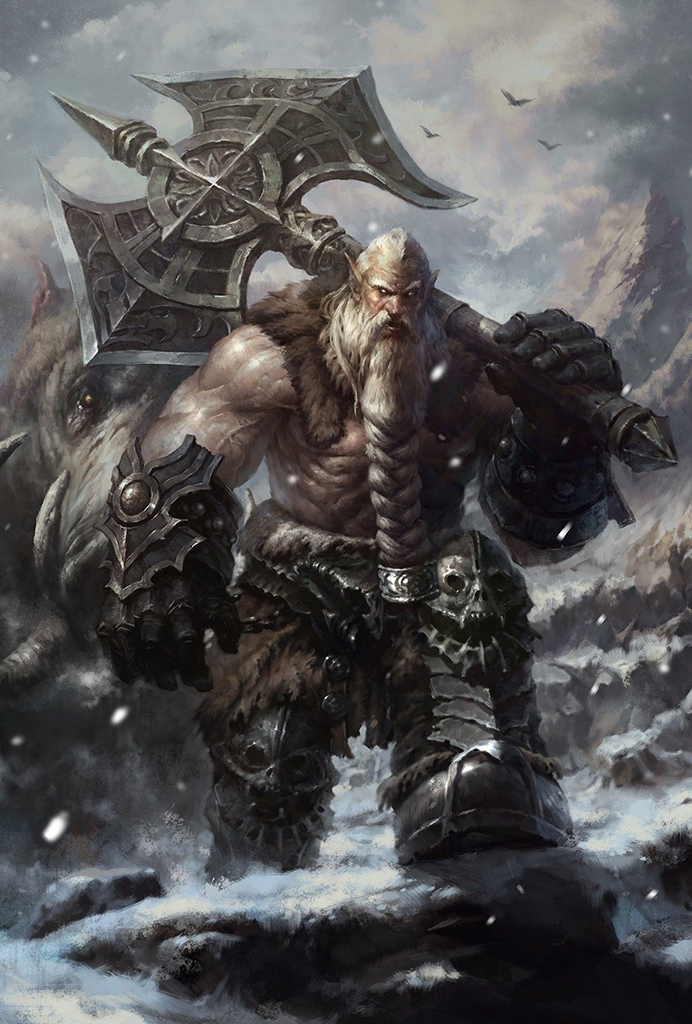

Query: heavy armored tank, fullsize picture
Portrait text: He is dressed in what seems to be heavy plate armor, indicating a class that is in the front lines of combat, such as a Fighter or Paladin, with a subclass
Similarity: 0.12562870979309082

Portrait nexusmods-pathfinderkingmaker-92-974/Dwarf/Melee/DW-MF-MS-M309/Fulllength.png already exists in query with matches {'fullsize', 'heavy armor', 'tank'}.
Is it correct? (y/n)

Answer: 

Is this portrait mathes 'fullsize'? (y/n)

Answer: 

Is this portrait mathes 'heavy armor'? (y/n)

Answer: 

Is this portrait mathes 'tank'? (y/n)

Answer: 

In [7]:
query = dataset[0].queries[0]
await check_query(query)